In [8]:
# 1. Import necessary libraries
import os
import zipfile
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Set Your File Name Here ---
# IMPORTANT: Change this to the exact name of your uploaded zip file
zip_file_name = "Synthetic Layered Images Segmentation.zip"
# -------------------------------

# Define paths
zip_file_path = os.path.join("/content/", zip_file_name)
destination_dir = "/content/data/synthetic images"

print(f"Zip file path: {zip_file_path}")
print(f"Destination directory: {destination_dir}")

Zip file path: /content/Synthetic Layered Images Segmentation.zip
Destination directory: /content/data/synthetic images


In [9]:
# 2. Create destination directory and unzip the file
if os.path.exists(zip_file_path):
    # Create the directory to extract to
    os.makedirs(destination_dir, exist_ok=True)

    print(f"Extracting '{zip_file_name}' to '{destination_dir}'...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(destination_dir)
    print("Extraction complete.")
else:
    print(f"Error: Zip file not found at '{zip_file_path}'")
    print("Please make sure you have uploaded the file and the 'zip_file_name' variable is correct.")

Extracting 'Synthetic Layered Images Segmentation.zip' to '/content/data/synthetic images'...
Extraction complete.


In [10]:
# 3. Verify contents and load file paths

# The directories are correct
image_dir = os.path.join(destination_dir, "images")
mask_dir = os.path.join(destination_dir, "masks")

# Check if the directories exist
if os.path.exists(image_dir) and os.path.exists(mask_dir):
    print(f"Found 'images' directory: {image_dir}")
    print(f"Found 'masks' directory: {mask_dir}")

    # --- FIX: Changed *.png to *.jpg ---
    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.jpg")))
    # -----------------------------------

    print(f"\nSuccessfully loaded {len(image_paths)} image paths.")
    print(f"Successfully loaded {len(mask_paths)} mask paths.")

    # Sanity check
    if len(image_paths) == 0:
        print("\nWarning: No images found. Check the file extension.")
    elif len(image_paths) != len(mask_paths):
        print("\nWarning: Mismatch between number of images and masks!")

else:
    print(f"\nError: Could not find 'images' or 'masks' directories inside '{destination_dir}'")
    print("Please check the directory structure.")

Found 'images' directory: /content/data/synthetic images/images
Found 'masks' directory: /content/data/synthetic images/masks

Successfully loaded 150 image paths.
Successfully loaded 150 mask paths.


In [11]:
# We already have os, glob, cv2, np, plt
# Let's add pandas for data handling, seaborn for plotting, and tqdm for progress bars
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# Set a nice plot style
sns.set(style="whitegrid")

Checking image sizes: 100%|██████████| 150/150 [00:00<00:00, 372.02it/s]


       width  height  aspect_ratio
count  150.0   150.0         150.0
mean   500.0   500.0           1.0
std      0.0     0.0           0.0
min    500.0   500.0           1.0
25%    500.0   500.0           1.0
50%    500.0   500.0           1.0
75%    500.0   500.0           1.0
max    500.0   500.0           1.0


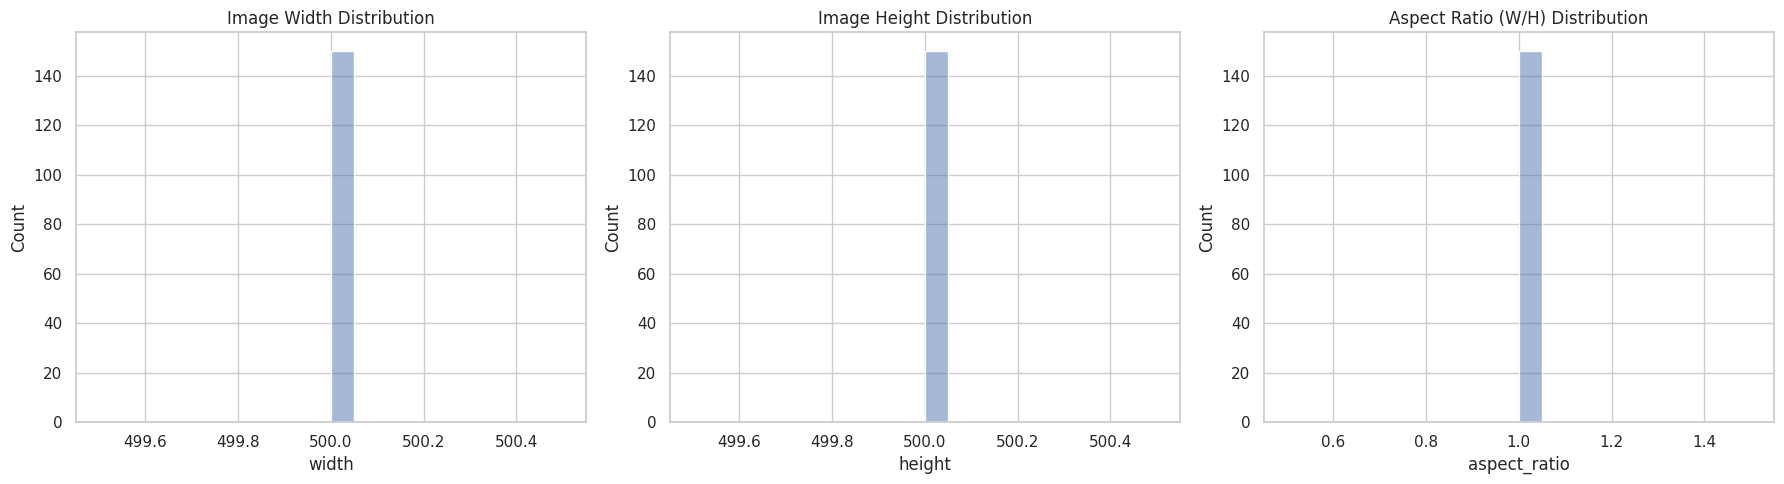

In [12]:
# 1. Loop through all images and get their dimensions
sizes = []
for img_path in tqdm(image_paths, desc="Checking image sizes"):
    try:
        # Read just the header to get size (faster, but cv2.imread is fine)
        img = cv2.imread(img_path)
        h, w, _ = img.shape
        sizes.append({'width': w, 'height': h, 'aspect_ratio': w/h})
    except Exception as e:
        print(f"Error reading {img_path}: {e}")

# 2. Convert to a DataFrame for easy plotting
df_sizes = pd.DataFrame(sizes)

# 3. Plot the distributions
if not df_sizes.empty:
    print(df_sizes.describe()) # Print statistics

    plt.figure(figsize=(18, 5))

    # Width
    plt.subplot(1, 3, 1)
    sns.histplot(df_sizes['width'], kde=True, bins=20)
    plt.title('Image Width Distribution')

    # Height
    plt.subplot(1, 3, 2)
    sns.histplot(df_sizes['height'], kde=True, bins=20)
    plt.title('Image Height Distribution')

    # Aspect Ratio
    plt.subplot(1, 3, 3)
    sns.histplot(df_sizes['aspect_ratio'], kde=True, bins=20)
    plt.title('Aspect Ratio (W/H) Distribution')

    plt.tight_layout()
    plt.show()
else:
    print("No image data to plot.")

Analyzing intensities: 100%|██████████| 30/30 [00:01<00:00, 23.77it/s]


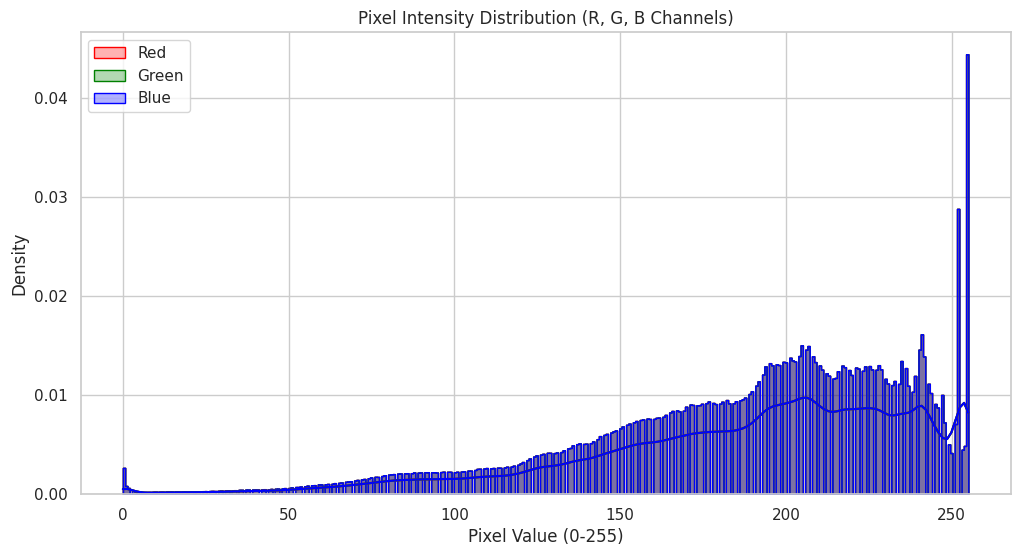

In [13]:
# 1. Sample ~30 images to analyze
num_samples = min(len(image_paths), 30)
sample_paths = np.random.choice(image_paths, num_samples, replace=False)

# 2. Collect pixel intensities
intensities = {'red': [], 'green': [], 'blue': []}

for img_path in tqdm(sample_paths, desc="Analyzing intensities"):
    img = cv2.imread(img_path)
    b, g, r = cv2.split(img) # OpenCV loads as BGR
    intensities['red'].extend(r.ravel())
    intensities['green'].extend(g.ravel())
    intensities['blue'].extend(b.ravel())

# 3. Plot the histograms
plt.figure(figsize=(12, 6))
sns.histplot(intensities['red'], color='red', label='Red', kde=True, stat="density", common_norm=False, element="step", alpha=0.3)
sns.histplot(intensities['green'], color='green', label='Green', kde=True, stat="density", common_norm=False, element="step", alpha=0.3)
sns.histplot(intensities['blue'], color='blue', label='Blue', kde=True, stat="density", common_norm=False, element="step", alpha=0.3)
plt.title('Pixel Intensity Distribution (R, G, B Channels)')
plt.xlabel('Pixel Value (0-255)')
plt.ylabel('Density')
plt.legend()
plt.show()

Analyzing masks: 100%|██████████| 150/150 [00:00<00:00, 755.67it/s]


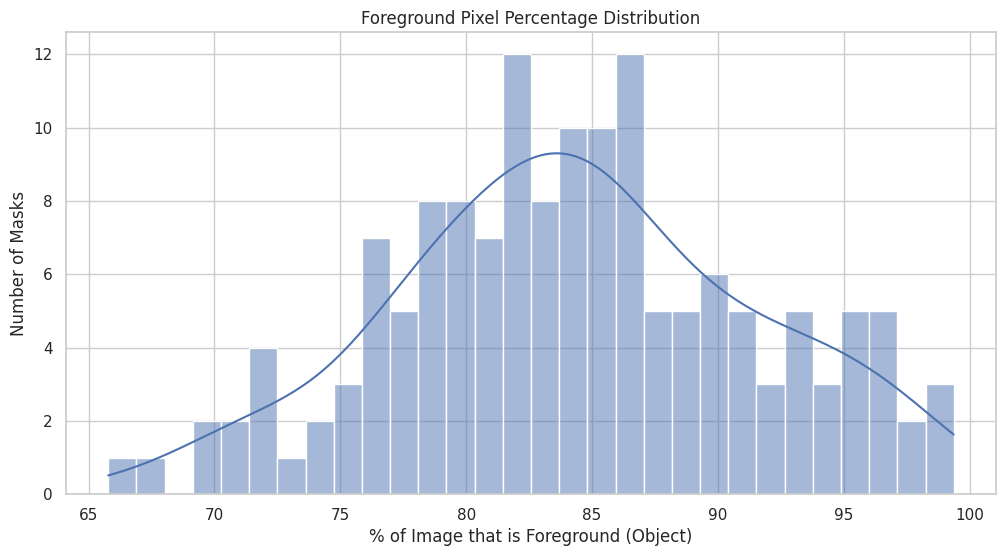

Average foreground object size: 84.29%
Median foreground object size: 84.18%
Smallest object: 65.78%
Largest object: 99.37%


In [14]:
# 1. Calculate foreground pixel percentage for every mask
fg_percentages = []
for mask_path in tqdm(mask_paths, desc="Analyzing masks"):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is not None:
        # Assuming 0 is background and >0 is foreground
        foreground_pixels = np.count_nonzero(mask)
        total_pixels = mask.size
        percentage = (foreground_pixels / total_pixels) * 100
        fg_percentages.append(percentage)

# 2. Plot the distribution
plt.figure(figsize=(12, 6))
sns.histplot(fg_percentages, kde=True, bins=30)
plt.title('Foreground Pixel Percentage Distribution')
plt.xlabel('% of Image that is Foreground (Object)')
plt.ylabel('Number of Masks')
plt.show()

# 3. Print key stats
if fg_percentages:
    print(f"Average foreground object size: {np.mean(fg_percentages):.2f}%")
    print(f"Median foreground object size: {np.median(fg_percentages):.2f}%")
    print(f"Smallest object: {np.min(fg_percentages):.2f}%")
    print(f"Largest object: {np.max(fg_percentages):.2f}%")

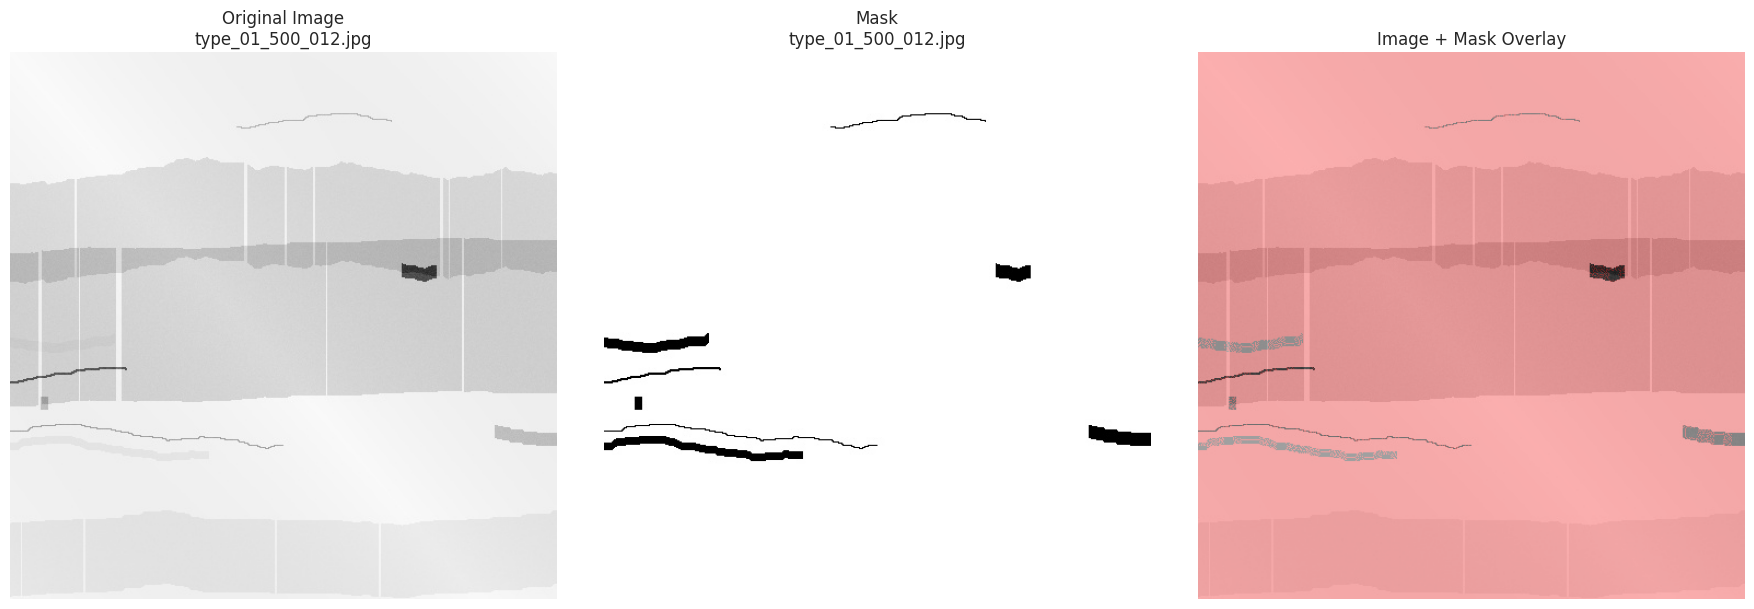

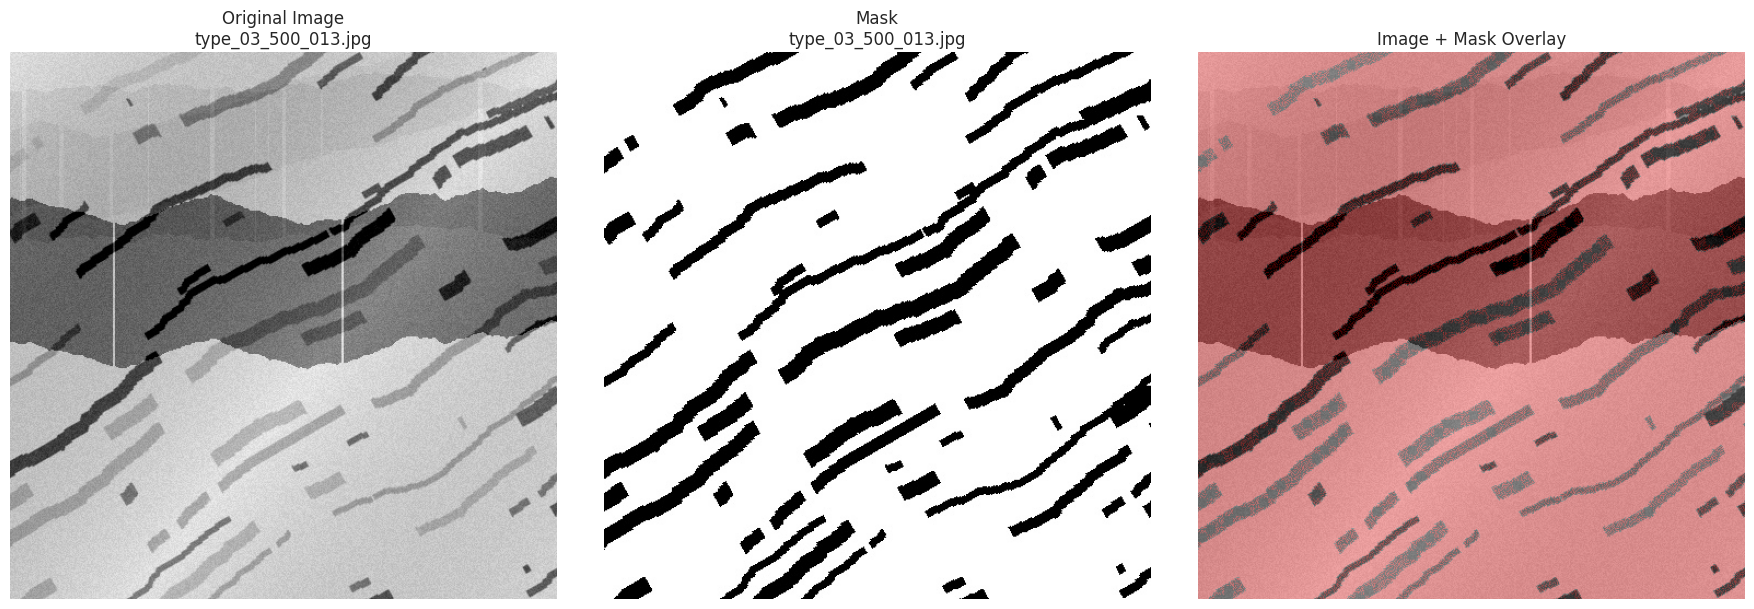

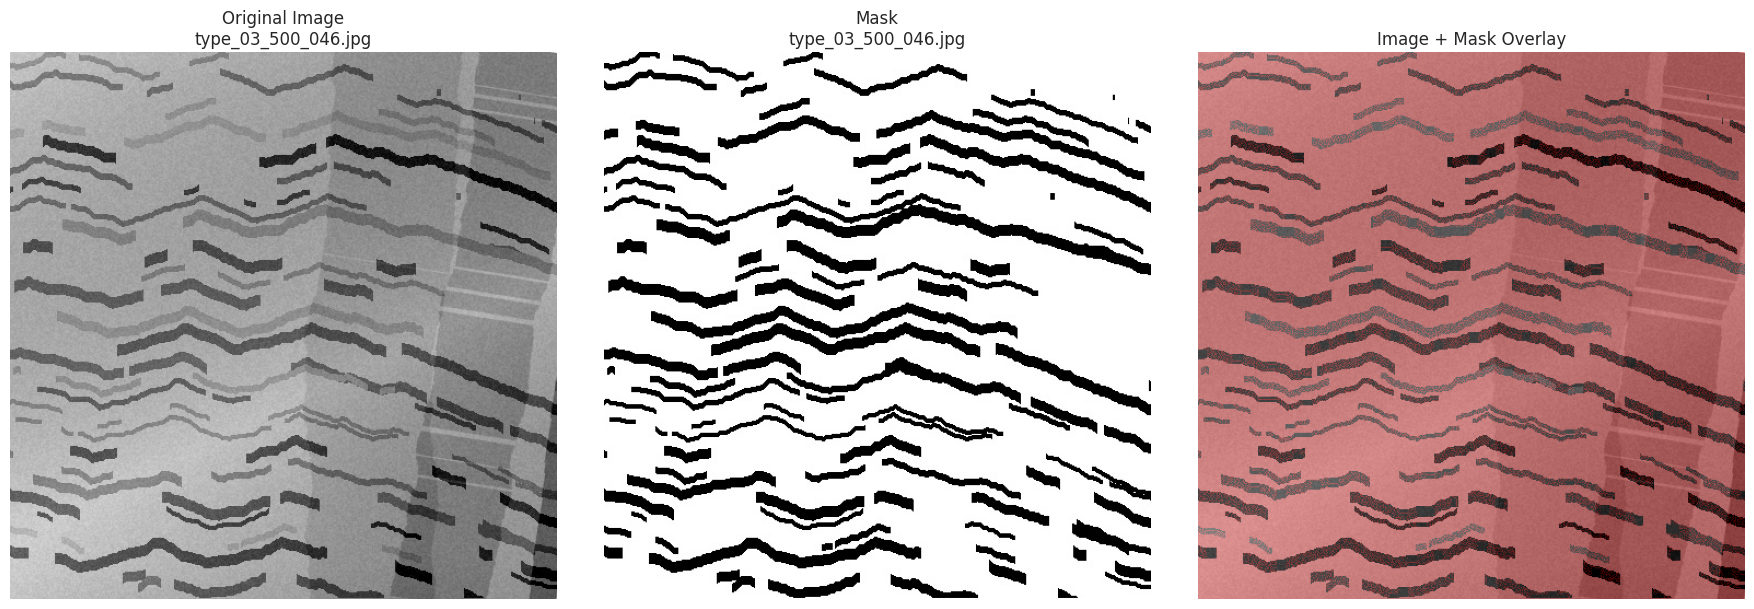

In [15]:
def show_sample(img_path, mask_path):
    """Loads and displays an image, its mask, and an overlay."""

    # Load image and convert to RGB
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load mask as grayscale
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Create a color overlay
    # 1. Create an empty 3-channel image
    mask_overlay = np.zeros_like(img, dtype=np.uint8)
    # 2. Set pixels to red where the mask is > 0
    mask_overlay[mask > 0] = [255, 0, 0] # Red

    # 3. Blend the image and the overlay
    # 70% image, 30% mask
    overlay = cv2.addWeighted(img, 0.7, mask_overlay, 0.3, 0)

    # Plotting
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Original Image\n{os.path.basename(img_path)}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask\n{os.path.basename(mask_path)}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Image + Mask Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- Run on 3 random samples ---
num_to_show = 3
sample_indices = np.random.choice(range(len(image_paths)), num_to_show, replace=False)

for idx in sample_indices:
    show_sample(image_paths[idx], mask_paths[idx])

In [16]:
!pip install -q albumentations

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define a single variable for image size
IMAGE_SIZE = 256

In [18]:
# Define the transformations for the TRAINING data
train_transforms = A.Compose([
    # 1. Preprocessing: Resize
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),

    # 2. Augmentation: Geometric
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.3),

    # 3. Augmentation: Color
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),

    # 4. Preprocessing: Normalize and convert to Tensor
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Define the transformations for the VALIDATION data
# NO augmentations here! Just preprocessing.
val_transforms = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [19]:
class NoisyImageDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transforms=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Albumentations expects RGB

        # Load mask
        mask_path = self.mask_paths[idx]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Apply augmentations
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'] # This is (H, W) numpy array, potentially with interpolated values

        # Explicitly binarize the mask to 0 or 255 after augmentations
        # This handles any intermediate values introduced by interpolation
        mask[mask > 127] = 255
        mask[mask <= 127] = 0

        # --- IMPORTANT MASK PROCESSING ---
        # The mask is now a (H, W) torch.uint8 tensor (values 0, 255)
        # We need a (1, H, W) torch.float tensor (values 0.0, 1.0)

        # 1. Convert to float and scale from [0, 255] to [0.0, 1.0]
        mask = (mask / 255.0).float()

        # 2. Add the channel dimension: (H, W) -> (1, H, W)
        mask = mask.unsqueeze(0)

        return image, mask

In [20]:
# 1. Split your data into training and validation sets (e.g., 80% train, 20% val)
TRAIN_RATIO = 0.8
BATCH_SIZE = 8 # You can tune this

# Use your loaded 'image_paths' and 'mask_paths' from before
train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, train_size=TRAIN_RATIO, random_state=42
)

print(f"Total images: {len(image_paths)}")
print(f"Training images: {len(train_img_paths)}")
print(f"Validation images: {len(val_img_paths)}")

# 2. Create the Dataset instances
train_dataset = NoisyImageDataset(train_img_paths, train_mask_paths, transforms=train_transforms)
val_dataset = NoisyImageDataset(val_img_paths, val_mask_paths, transforms=val_transforms)

# 3. Create the DataLoader instances
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # Shuffle training data
    num_workers=0 # Set to 0 for Colab compatibility to avoid multiprocessing issues
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    num_workers=0 # Set to 0 for Colab compatibility to avoid multiprocessing issues
)

Total images: 150
Training images: 120
Validation images: 30


Verifying the training dataloader...
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 1, 256, 256])


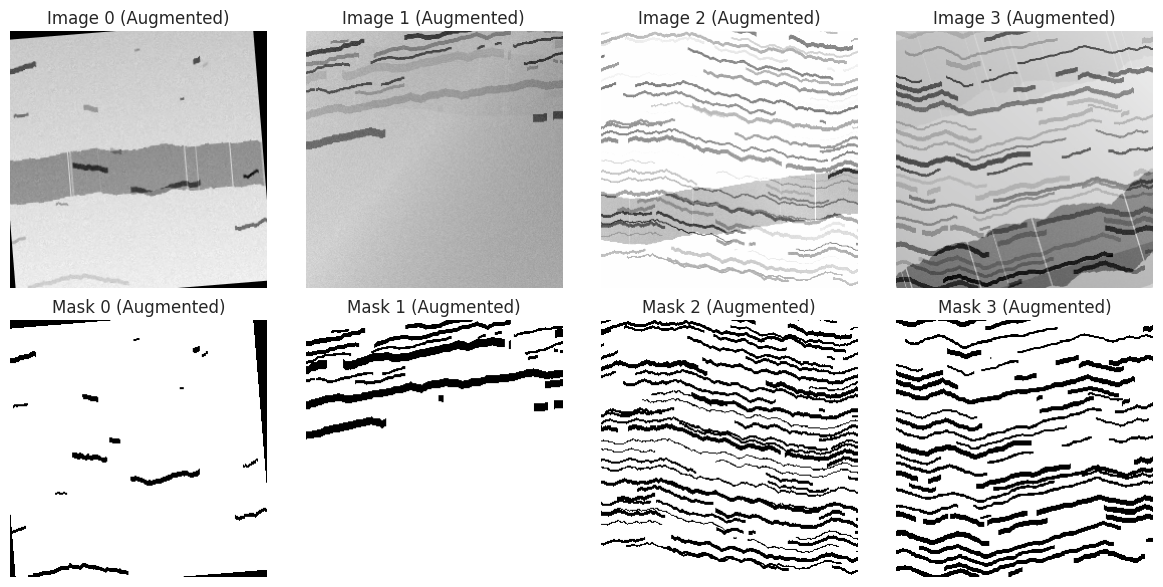

In [21]:
print("Verifying the training dataloader...")

# Get one batch
images, masks = next(iter(train_loader))

print(f"Image batch shape: {images.shape}") # Should be [B, 3, H, W]
print(f"Mask batch shape: {masks.shape}")   # Should be [B, 1, H, W]

# --- Plot a few samples ---
def show_batch(images, masks, n_samples=4):
    plt.figure(figsize=(12, 6))

    # Clamp n_samples to the batch size
    n_samples = min(n_samples, len(images))

    for i in range(n_samples):
        # --- Image ---
        plt.subplot(2, n_samples, i + 1)
        img = images[i] # This is a (3, H, W) normalized tensor

        # Un-normalize for display
        img = img.permute(1, 2, 0).cpu().numpy() # (H, W, 3)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.title(f"Image {i} (Augmented)")
        plt.axis('off')

        # --- Mask ---
        plt.subplot(2, n_samples, i + 1 + n_samples)
        mask = masks[i].squeeze(0).cpu().numpy() # (H, W)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask {i} (Augmented)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_batch(images, masks)

In [22]:
!pip install -q segmentation-models-pytorch
!pip install -q torchmetrics
!pip install -q torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 44.1 MB/s eta 0:00:00


In [23]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import segmentation_models_pytorch as smp
from transformers import SegformerForSemanticSegmentation, SegformerConfig

# We'll need these from the previous step
# (Assuming they are in memory)
# train_loader, val_loader

# Set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [24]:
# --- Option A: U-Net ---

# We can use a pre-trained ResNet34 backbone for the encoder
# This is much more powerful than a plain U-Net
model_unet = smp.Unet(
    encoder_name="resnet34",        # Use a pre-trained ResNet34
    encoder_weights="imagenet",     # Load weights pre-trained on ImageNet
    in_channels=3,                  # 3 input channels (RGB)
    classes=1,                      # 1 output channel (for our binary mask)
    activation=None                 # CRITICAL FIX: Output raw logits for consistency with DiceLoss (from_logits=True)
).to(DEVICE)

# --- Uncomment one of the lines below to choose your model ---
model = model_unet

print("U-Net model loaded.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

U-Net model loaded.


In [25]:
# --- Loss Function ---
# This is a combination of Dice Loss and Binary Cross-Entropy
# It's stable and works well for imbalanced segmentation
# This loss expects model outputs (preds) to be logits (raw, no sigmoid)
loss_fn = smp.losses.DiceLoss(mode='binary', from_logits=True)
# Or use a combo:
# bce_loss = nn.BCEWithLogitsLoss()
# dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=True)
# loss_fn = lambda preds, target: 0.5 * bce_loss(preds, target) + 0.5 * dice_loss(preds, target)


# --- Metrics ---
# We'll track Dice Score (also called F1-score)
# 'threshold=0.5' means we'll consider any pixel output > 0.5 as "foreground"
metrics = [
    smp.metrics.iou_score,
    smp.metrics.f1_score,
]

# --- Optimizer ---
# You must re-run this cell if you change the 'model' variable!
try:
    LEARNING_RATE = 1e-4
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
except NameError:
    print("Please uncomment one of the model definitions (model = ...) and re-run.")

In [26]:
def train_fn(loader, model, optimizer, loss_fn, device):
    """
    Performs one epoch of training.
    """
    model.train() # Set model to training mode

    loop = tqdm(loader, desc="Training")
    running_loss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device)

        # --- Forward Pass ---
        # SegFormer returns a tuple, U-Net returns a tensor
        # If model outputs logits, loss_fn should have from_logits=True
        # If model outputs probabilities, loss_fn should have from_logits=False
        # For consistency and numerical stability, it's best for the model to output logits.
        # This requires changing U-Net activation to None.
        if isinstance(model, SegformerForSemanticSegmentation):
            outputs = model(data)
            # SegFormer logits are at outputs.logits
            # They are [Batch, Num_Labels, H, W].
            # We need [Batch, 1, H, W] for our binary loss.
            # We take the logit for the "foreground" class (channel 1)
            predictions = outputs.logits[:, 1, :, :].unsqueeze(1) # -> [B, 1, H, W]

            # We also need to resize the logits to match the target mask size
            predictions = nn.functional.interpolate(
                predictions,
                size=targets.shape[2:], # (H, W) of the target
                mode='bilinear',
                align_corners=False
            )

        else: # For U-Net (assuming activation=None now)
            predictions = model(data) # -> [B, 1, H, W] (raw logits)

        # --- Calculate Loss ---
        loss = loss_fn(predictions, targets) # loss_fn expects logits due to from_logits=True

        # --- Backward Pass ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar
        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return running_loss / len(loader)


def eval_fn(loader, model, loss_fn, metrics_fns, device):
    """
    Performs one epoch of validation.
    """
    model.eval() # Set model to evaluation mode

    val_loss = 0.0
    # We need to accumulate TP, FP, FN, TN across batches
    total_tp = 0
    total_fp = 0
    total_fn = 0
    total_tn = 0

    loop = tqdm(loader, desc="Validating")

    with torch.no_grad(): # No gradients needed
        for batch_idx, (data, targets) in enumerate(loop):
            data = data.to(device=device)
            targets = targets.to(device=device)

            # --- Forward Pass ---
            if isinstance(model, SegformerForSemanticSegmentation):
                outputs = model(data)
                predictions = outputs.logits[:, 1, :, :].unsqueeze(1)
                predictions = nn.functional.interpolate(
                    predictions,
                    size=targets.shape[2:],
                    mode='bilinear',
                    align_corners=False
                )
            else: # For U-Net (assuming activation=None now)
                predictions = model(data) # This will be raw logits

            # --- Calculate Loss (expects logits) ---
            loss = loss_fn(predictions, targets)
            val_loss += loss.item()

            # --- Calculate Metrics ---
            # The smp.metrics functions expect TP, FP, FN, TN or thresholded inputs.
            # Since model outputs logits, we first apply sigmoid to get probabilities,
            # then threshold to get binary predictions.
            # Targets are already 0.0 or 1.0 floats from the dataset.

            # Apply sigmoid to logits to get probabilities (0-1)
            probabilities = torch.sigmoid(predictions)

            # Threshold probabilities to get binary predictions (0 or 1)
            # Ensure targets are also strictly binary (0 or 1) long type for get_stats
            thresholded_predictions = (probabilities > 0.5).long()
            binary_targets = (targets > 0.5).long()

            # Calculate TP, FP, FN, TN for the current batch
            tp, fp, fn, tn = smp.metrics.get_stats(
                thresholded_predictions,
                binary_targets,
                mode='binary',
                threshold=None # Already thresholded
            )

            # Accumulate across batches
            total_tp += tp.sum()
            total_fp += fp.sum()
            total_fn += fn.sum()
            total_tn += tn.sum()

    val_loss /= len(loader)

    # Calculate final metrics using the accumulated stats
    final_metric_scores = {}
    for metric_fn in metrics_fns:
        score = metric_fn(
            tp=total_tp,
            fp=total_fp,
            fn=total_fn,
            tn=total_tn,
            reduction='micro' # Aggregate over all samples/pixels
        )
        final_metric_scores[metric_fn.__name__] = score.item()

    print(f"Validation Loss: {val_loss:.4f}")
    for key, value in final_metric_scores.items():
        print(f"Validation {key}: {value:.4f}")

    return val_loss, final_metric_scores

In [27]:
# --- Make sure you have selected a 'model' in section 3 ---
# --- and run section 4 to define the 'optimizer' ---

NUM_EPOCHS = 10 # Start with 10-20
best_val_score = 0.0 # We'll save the model with the best Dice score

for epoch in range(NUM_EPOCHS):
    print(f"--- Epoch {epoch+1}/{NUM_EPOCHS} ---")

    train_loss = train_fn(
        train_loader, model, optimizer, loss_fn, DEVICE
    )

    val_loss, val_metrics = eval_fn(
        val_loader, model, loss_fn, metrics, DEVICE
    )

    # --- Save the best model ---
    # We use 'f1_score' (Dice) as our main metric
    current_val_score = val_metrics['f1_score']

    if current_val_score > best_val_score:
        best_val_score = current_val_score
        print(f"🎉 New best model! Dice: {best_val_score:.4f}. Saving model...")
        torch.save(model.state_dict(), "best_model.pth")

print("\n--- Training Complete ---")
print(f"Best Validation Dice Score: {best_val_score:.4f}")

--- Epoch 1/10 ---


Validating: 100%|██████████| 4/4 [00:00<00:00, 13.07it/s]


Validation Loss: 0.3439
Validation iou_score: 0.5768
Validation f1_score: 0.7316
🎉 New best model! Dice: 0.7316. Saving model...
--- Epoch 2/10 ---


Validating: 100%|██████████| 4/4 [00:00<00:00, 14.47it/s]


Validation Loss: 0.2711
Validation iou_score: 0.7212
Validation f1_score: 0.8380
🎉 New best model! Dice: 0.8380. Saving model...
--- Epoch 3/10 ---


Validating: 100%|██████████| 4/4 [00:00<00:00, 15.25it/s]


Validation Loss: 0.2126
Validation iou_score: 0.8004
Validation f1_score: 0.8891
🎉 New best model! Dice: 0.8891. Saving model...
--- Epoch 4/10 ---


Validating: 100%|██████████| 4/4 [00:00<00:00, 14.58it/s]


Validation Loss: 0.1768
Validation iou_score: 0.8498
Validation f1_score: 0.9188
🎉 New best model! Dice: 0.9188. Saving model...
--- Epoch 5/10 ---


Validating: 100%|██████████| 4/4 [00:00<00:00, 15.07it/s]


Validation Loss: 0.1602
Validation iou_score: 0.8658
Validation f1_score: 0.9281
🎉 New best model! Dice: 0.9281. Saving model...
--- Epoch 6/10 ---


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.00it/s]


Validation Loss: 0.1415
Validation iou_score: 0.8845
Validation f1_score: 0.9387
🎉 New best model! Dice: 0.9387. Saving model...
--- Epoch 7/10 ---


Validating: 100%|██████████| 4/4 [00:00<00:00, 14.57it/s]


Validation Loss: 0.1309
Validation iou_score: 0.8908
Validation f1_score: 0.9422
🎉 New best model! Dice: 0.9422. Saving model...
--- Epoch 8/10 ---


Validating: 100%|██████████| 4/4 [00:00<00:00, 14.82it/s]


Validation Loss: 0.1295
Validation iou_score: 0.8954
Validation f1_score: 0.9448
🎉 New best model! Dice: 0.9448. Saving model...
--- Epoch 9/10 ---


Validating: 100%|██████████| 4/4 [00:00<00:00,  8.24it/s]


Validation Loss: 0.1216
Validation iou_score: 0.8984
Validation f1_score: 0.9465
🎉 New best model! Dice: 0.9465. Saving model...
--- Epoch 10/10 ---


Validating: 100%|██████████| 4/4 [00:00<00:00,  9.11it/s]


Validation Loss: 0.1136
Validation iou_score: 0.9039
Validation f1_score: 0.9495
🎉 New best model! Dice: 0.9495. Saving model...

--- Training Complete ---
Best Validation Dice Score: 0.9495


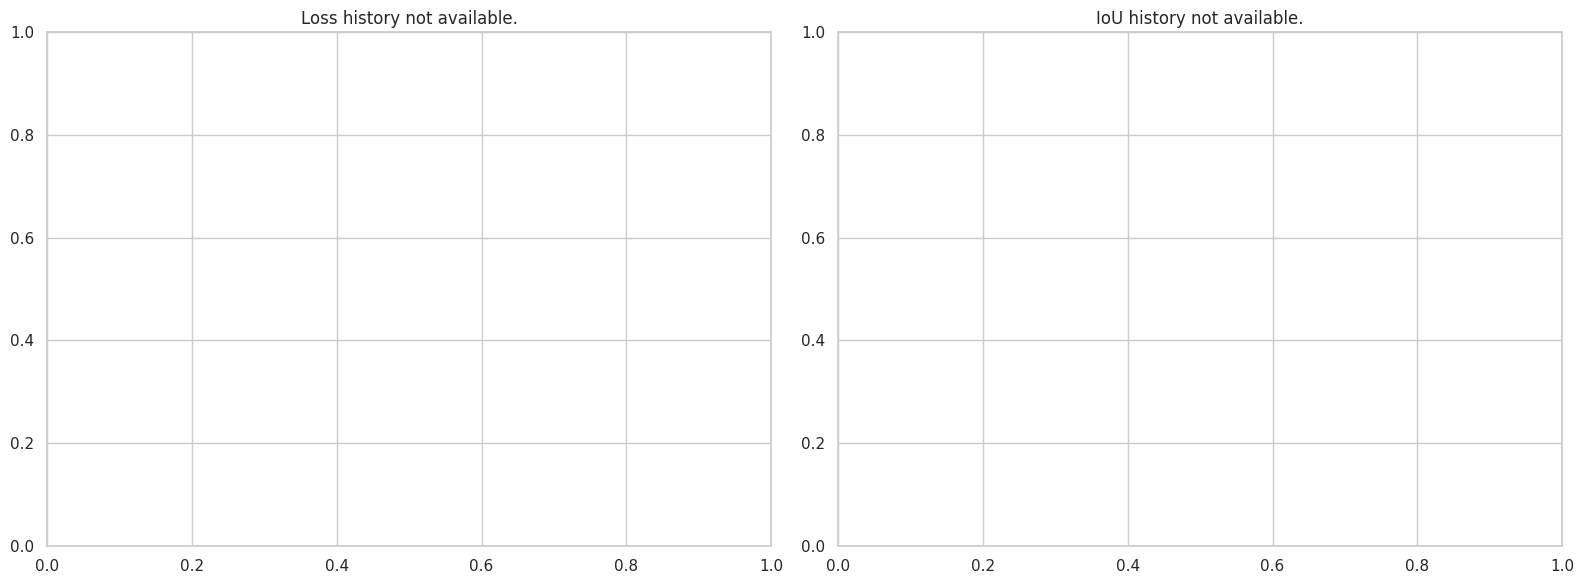

In [28]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
plt.figure(figsize=(16, 6))
epochs_range = range(1, NUM_EPOCHS + 1)

# --- Subplot 1: Loss ---
plt.subplot(1, 2, 1)
# Check if history lists exist before plotting
if 'train_loss_history' in globals() and 'val_loss_history' in globals():
    plt.plot(epochs_range, train_loss_history, 'b-', label='Training Loss')
    plt.plot(epochs_range, val_loss_history, 'orange', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
else:
    plt.title("Loss history not available.")

# --- Subplot 2: IoU (Jaccard) ---
plt.subplot(1, 2, 2)
if 'train_iou_history' in globals() and 'val_iou_history' in globals():
    plt.plot(epochs_range, train_iou_history, 'b-', label='Training IoU')
    plt.plot(epochs_range, val_iou_history, 'orange', label='Validation IoU')
    plt.title('Training and Validation IoU (Jaccard Index)')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True)
else:
    plt.title("IoU history not available.")

plt.tight_layout()
plt.show()

Displaying predictions from the validation set...


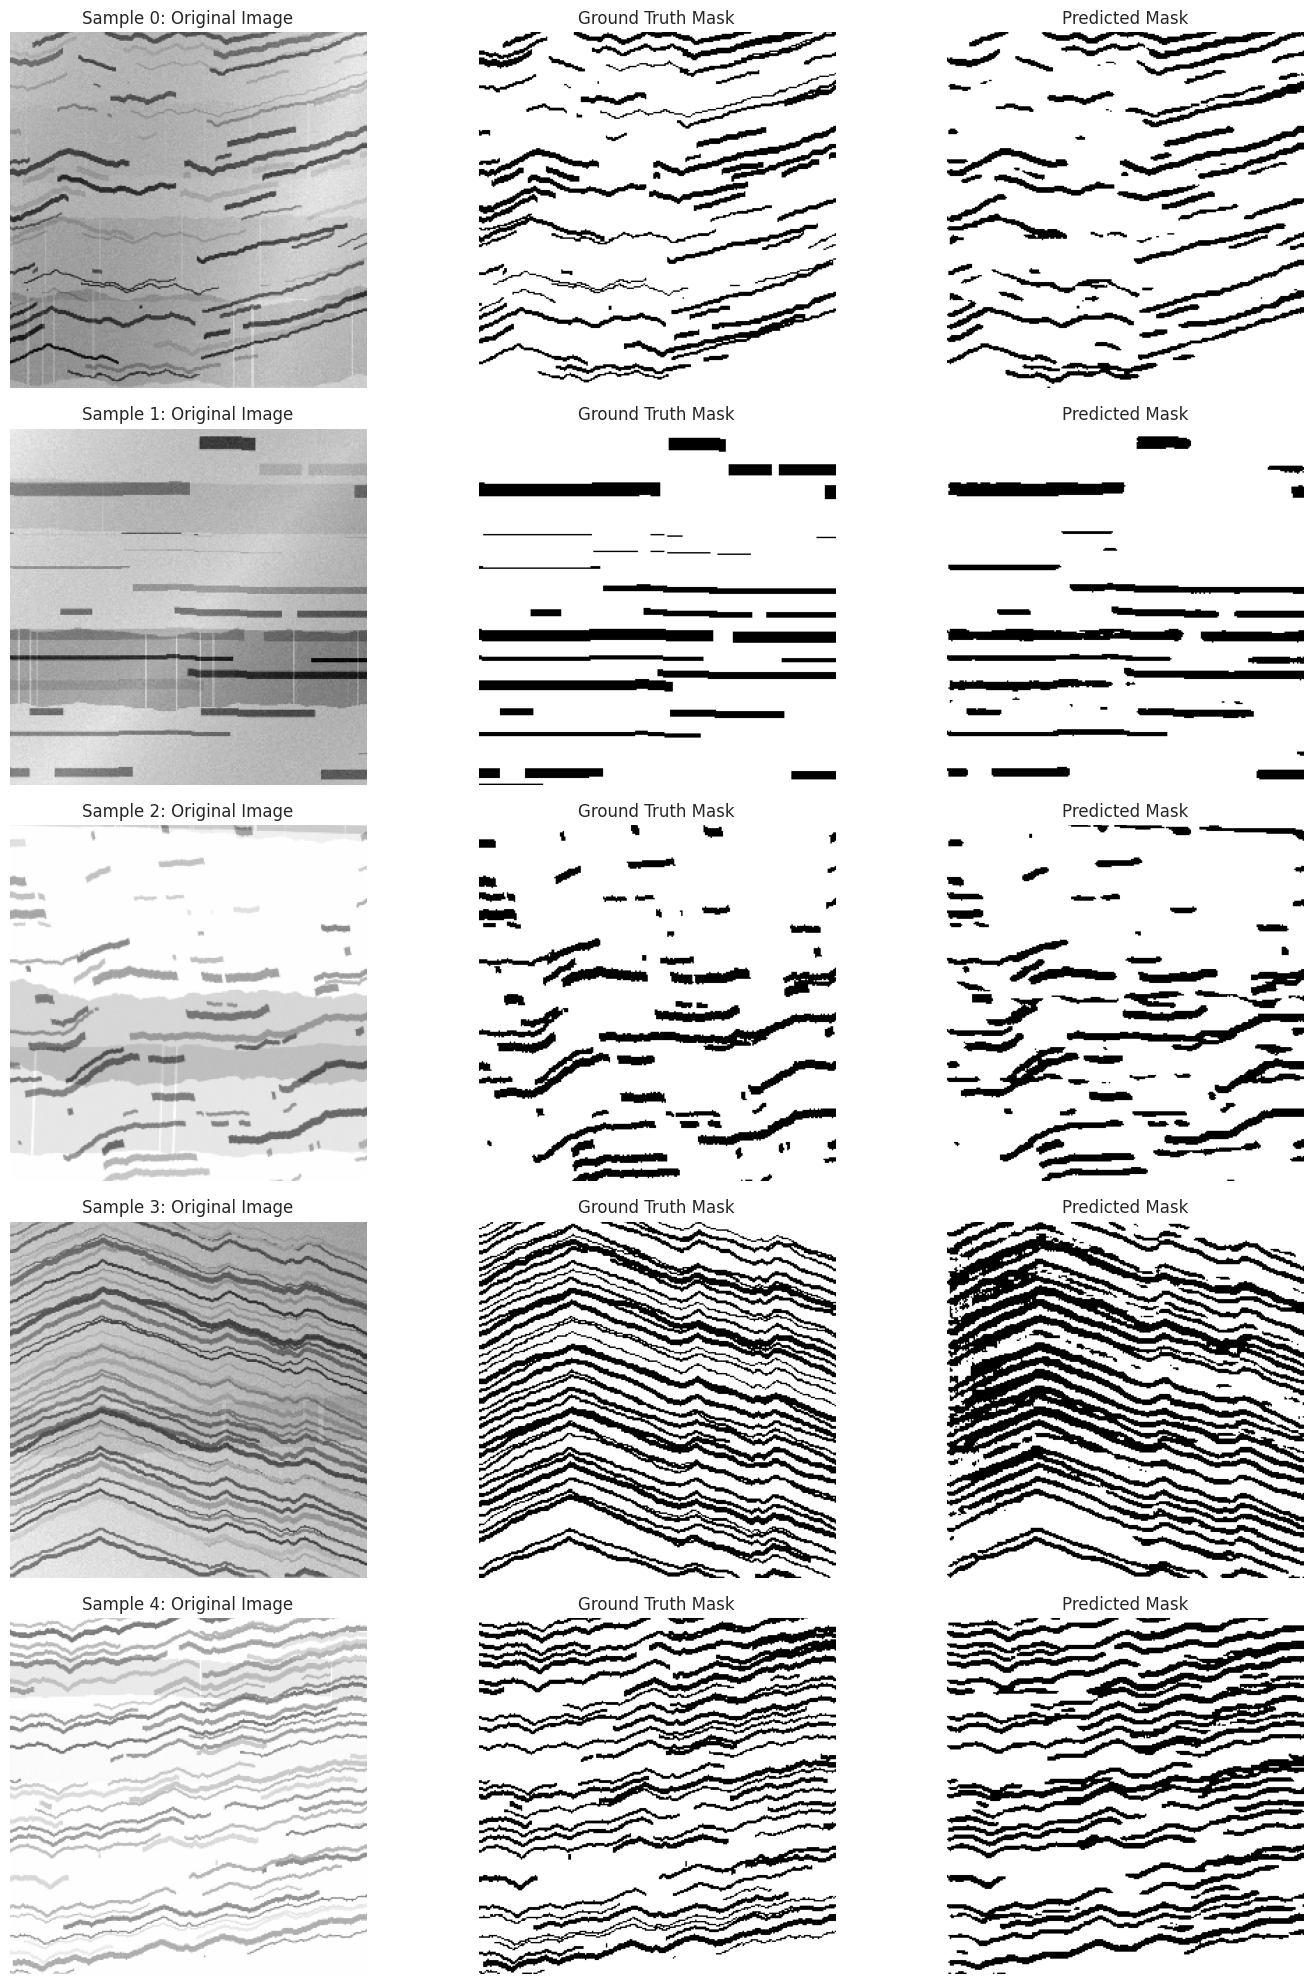

In [29]:
def unnormalize_image(tensor):
    """Reverses the ImageNet normalization for display."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # .permute(1, 2, 0) changes from (C, H, W) to (H, W, C)
    img = tensor.permute(1, 2, 0).cpu().numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1) # Ensure values are between 0 and 1
    return img

def visualize_predictions(loader, num_to_show=5):
    """Shows the Original Image, True Mask, and Predicted Mask."""

    model.eval() # Set model to evaluation mode

    # Get one batch of data from the validation loader
    try:
        images, masks = next(iter(loader))
    except StopIteration:
        print("Error: DataLoader is empty.")
        return

    images, masks = images.to(DEVICE), masks.to(DEVICE)

    with torch.no_grad():
        logits = model(images)
        # Get probabilities
        probs = torch.sigmoid(logits)
        # Get binary predictions
        preds = (probs > 0.5).float()

    # Move to CPU for plotting
    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()

    # Plot
    plt.figure(figsize=(15, num_to_show * 4))

    for i in range(num_to_show):
        if i >= len(images): break # In case batch size is smaller than num_to_show

        # --- 1. Original Image (Unnormalized) ---
        plt.subplot(num_to_show, 3, i * 3 + 1)
        plt.imshow(unnormalize_image(images[i]))
        plt.title(f"Sample {i}: Original Image")
        plt.axis('off')

        # --- 2. Ground Truth Mask ---
        plt.subplot(num_to_show, 3, i * 3 + 2)
        # .squeeze() removes the channel dim (1, H, W) -> (H, W)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # --- 3. Predicted Mask ---
        plt.subplot(num_to_show, 3, i * 3 + 3)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- Run the visualization ---
print("Displaying predictions from the validation set...")
visualize_predictions(val_loader, num_to_show=5)

Calculating final metrics on the entire validation set...


Final Evaluation: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]



--- Final Validation Metrics ---
Accuracy:   0.9205
Precision:  0.9602
Recall:     0.9391
F1-Score:   0.9495
IoU (Jaccard): 0.9039
----------------------------------


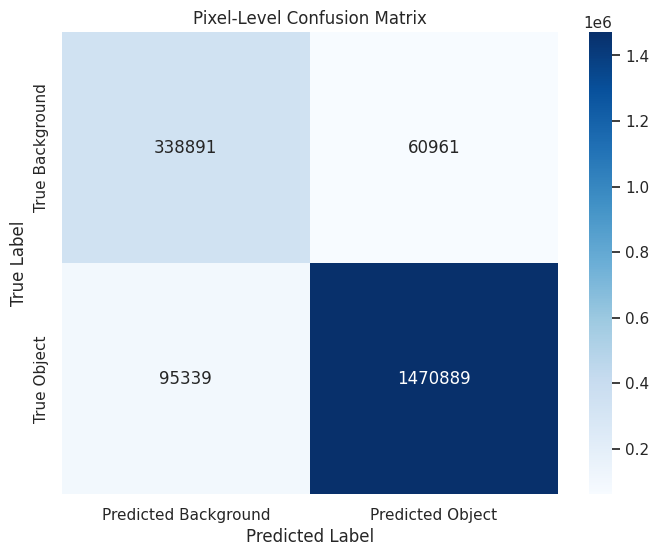

In [30]:
import seaborn as sns
from torchmetrics import ConfusionMatrix
import torchmetrics

# --- 1. Initialize all metrics and CM for final evaluation ---
# Make sure metrics_config is defined from your training script
metrics_config = {
    "task": "binary",
    "threshold": 0.5,
}

# Instantiate metrics without the device argument
final_accuracy = torchmetrics.Accuracy(**metrics_config).to(DEVICE)
final_precision = torchmetrics.Precision(**metrics_config).to(DEVICE)
final_recall = torchmetrics.Recall(**metrics_config).to(DEVICE)
final_f1 = torchmetrics.F1Score(**metrics_config).to(DEVICE)
final_iou = torchmetrics.JaccardIndex(**metrics_config).to(DEVICE)
final_cm = ConfusionMatrix(task="binary", threshold=0.5).to(DEVICE)

#  2. Loop through the entire validation set
print("Calculating final metrics on the entire validation set...")
model.eval()
with torch.no_grad():
    for images, masks in tqdm(val_loader, desc="Final Evaluation"):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        logits = model(images)
        probs = torch.sigmoid(logits)

        # Update all metrics
        final_accuracy.update(probs, masks)
        final_precision.update(probs, masks)
        final_recall.update(probs, masks)
        final_f1.update(probs, masks)
        final_iou.update(probs, masks)
        final_cm.update(probs, masks)

#  3. Compute and Print Final Scores
acc = final_accuracy.compute()
prec = final_precision.compute()
rec = final_recall.compute()
f1 = final_f1.compute()
iou = final_iou.compute()

print("\n--- Final Validation Metrics ---")
print(f"Accuracy:   {acc.item():.4f}")
print(f"Precision:  {prec.item():.4f}")
print(f"Recall:     {rec.item():.4f}")
print(f"F1-Score:   {f1.item():.4f}")
print(f"IoU (Jaccard): {iou.item():.4f}")
print("----------------------------------")

# 4. Compute and Plot Confusion Matrix
cm = final_cm.compute().cpu().numpy()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Background', 'Predicted Object'],
            yticklabels=['True Background', 'True Object'])
plt.title('Pixel-Level Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [31]:
import torch
import segmentation_models_pytorch as smp

# --- 1. Define the model structure (must be identical) ---
# Make sure DEVICE, IMAGE_SIZE, etc. are defined
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_SIZE = 256 # Should be the same size you trained with

model_to_load = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None, # No need to load "imagenet" weights, we have our own
    in_channels=3,
    classes=1,
    activation=None
)

# --- 2. Load your saved weights ---
model_path = "best_model.pth"
try:
    model_to_load.load_state_dict(torch.load(model_path, map_location=DEVICE))
    print(f"Successfully loaded model from {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Did you make sure the model architecture is identical?")

# --- 3. Set to evaluation mode and move to device ---
model_to_load.to(DEVICE)
model_to_load.eval()

# 'model_to_load' is now ready for inference!

Successfully loaded model from best_model.pth


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [32]:
!pip install -q onnx onnx-tf tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.6/186.6 kB 20.8 MB/s eta 0:00:00


In [33]:
import torch.onnx

# Ensure your model is loaded and in eval mode (from the code above)
if 'model_to_load' in globals():
    model_to_load.eval()

    # 2. Create a dummy input tensor with the correct shape
    # (Batch_Size, Channels, Height, Width)
    dummy_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)

    onnx_path = "best_model.onnx"

    print(f"Exporting model to ONNX format at {onnx_path}...")
    try:
        torch.onnx.export(
            model_to_load,
            dummy_input,
            onnx_path,
            export_params=True,
            opset_version=11, # A widely compatible version
            input_names=['input'],
            output_names=['output'],
            dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
        )
        print("ONNX export successful.")

    except Exception as e:
        print(f"ONNX export failed: {e}")

else:
    print("Please run the model loading code block from Part 1 first.")

Exporting model to ONNX format at best_model.onnx...


/tmp/ipython-input-674726415.py:15: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


ONNX export successful.


In [54]:
import torch
import segmentation_models_pytorch as smp
import os # Make sure os is imported to check file size

# --- 1. Load Your Best Model (Same as before) ---
DEVICE = "cpu" # Set to CPU for scripting
IMAGE_SIZE = 256

model_to_load = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None
)
model_path = "best_model.pth"
model_to_load.load_state_dict(torch.load(model_path, map_location=DEVICE))
model_to_load.to(DEVICE)
model_to_load.eval()
print("Model loaded successfully.")

# --- 2. Convert to PyTorch Mobile (The Stable Way) ---
ptl_path = "model.ptl"

try:
    # 1. Create a dummy input
    dummy_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)

    # 2. Trace the model
    scripted_model = torch.jit.trace(model_to_load, dummy_input)

    # 3. Save using the optimized lite interpreter method
    scripted_model._save_for_lite_interpreter(ptl_path)

    print(f"\nSuccessfully exported to PyTorch Mobile format: {ptl_path}")
    print(f"File size: {os.path.getsize(ptl_path) / (1024*1024):.2f} MB")

except Exception as e:
    print(f"\nError during PTL export: {e}")

Model loaded successfully.

Successfully exported to PyTorch Mobile format: model.ptl
File size: 93.67 MB
